In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

from utils_ode import *
from odes_hd import *
from utils_verify import max_lyapunov_benettin
from utils_ode import parse_ode_equations, plot_3d_ode, plot_power_spectrum

from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [5]:
vecs = np.load('./results/exp_verbose/vecs_lorenz_tiny_rcp_transfer_exp_verbose.npy')
#vecs = np.load('./results/exp_simple/vecs_lorenz_tiny_rcp_transfer_exp_simple.npy')

dx/dt = 0.5246*1 + -10.1084*x + 8.8595*y + -0.8668*z + 0.7472*x^2 + 0.3193*x*y + 1.3702*x*z + -0.5378*y^2 + -0.0261*y*z + 0.1221*z^2
dy/dt = -11.7821*1 + 24.4366*x + -0.7102*y + 21.6753*z + 0.1640*x*y + -43.6136*x*z + -0.3814*y^2 + 0.0646*y*z + 0.1181*z^2 + 0.0598*y*x/(x+0.16129)
dz/dt = 10.7439*1 + -21.9901*x + -21.2005*y + -2.3336*z + 0.6840*x^2 + 41.7767*x*y + 0.2184*x*z + -0.2071*y*z + -0.0220*z^2 + 0.7380*y*x/(x+0.16129) + -0.0330*y*z/(y+0.5)


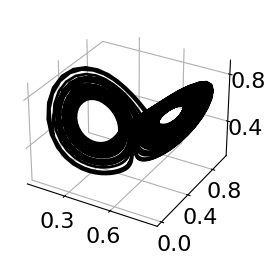

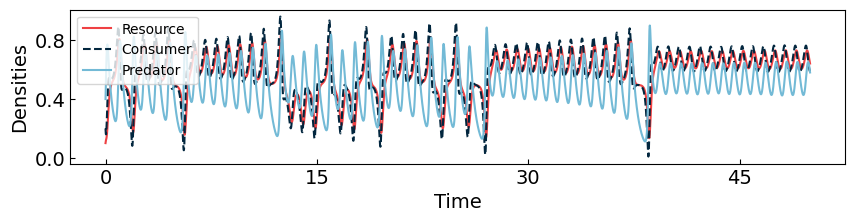

In [10]:
class VectorFieldModelComponents:
    def __init__(self, grid_limits, grid_shape, basis_funcs):
        """
        grid_limits: 每个维度的取值区间，例如 [[0,1], [0,1], [0,1]]
        grid_shape: 每个维度的点数，例如 (48,48,48)
        basis_funcs: 字典，键为 'x','y','z'（表示向量场各分量），
                     值为对应分量的基函数列表，每个元素为 (f, name) 的元组，
                     其中 f(x,y,z) 为实现，name 为该基函数的字符串描述。
        """
        self.grid_limits = grid_limits
        self.grid_shape = grid_shape
        self.basis_funcs = basis_funcs
        self.coeffs = {}  # 存储各分量的拟合系数，格式为字典，键 'x','y','z'
        self._generate_grid()
        
    def _generate_grid(self):
        # 根据网格参数生成各维度的坐标和三维网格
        self.grids = [np.linspace(lim[0], lim[1], num) 
                      for lim, num in zip(self.grid_limits, self.grid_shape)]
        self.xg, self.yg, self.zg = self.grids
        # 使用 indexing='ij' 保证网格顺序与数据对应
        x, y, z = np.meshgrid(self.xg, self.yg, self.zg, indexing='ij')
        self.x = x
        self.y = y
        self.z = z
        self.N = x.size
        # 将三维坐标展平成一维数组（形状均为 (N,)）
        self.x_flat = x.flatten()
        self.y_flat = y.flatten()
        self.z_flat = z.flatten()
    
    def _build_design_matrix_component(self, comp):
        """
        为向量场分量 comp（'x','y','z'）构建设计矩阵，
        每个基函数 f(x,y,z) 返回形状为 (N,) 的数组
        """
        funcs = self.basis_funcs[comp]
        # 注意：这里每个元素是一个 (f, name) 元组
        X = np.column_stack([f(self.x_flat, self.y_flat, self.z_flat) for f, name in funcs])
        return X
    
    def fit(self, vecs, regression="linear", alpha=1.0):
        """
        vecs: 向量场数据，形状应为 (grid_shape..., 3)
        regression: 使用的回归方法，取值 "linear"、"lasso" 或 "ridge"
        alpha: 正则化参数（仅对 lasso 和 ridge 有效）
        
        分别构建设计矩阵并拟合各分量的系数
        """
        # 构建设计矩阵
        X_x = self._build_design_matrix_component('x')
        X_y = self._build_design_matrix_component('y')
        X_z = self._build_design_matrix_component('z')
        
        # 展平向量场数据各分量
        vecs_x = vecs[:, :, :, 0].flatten()
        vecs_y = vecs[:, :, :, 1].flatten()
        vecs_z = vecs[:, :, :, 2].flatten()
        
        # 根据选择的回归方法拟合
        if regression == "linear":
            model_x = LinearRegression(fit_intercept=False).fit(X_x, vecs_x)
            model_y = LinearRegression(fit_intercept=False).fit(X_y, vecs_y)
            model_z = LinearRegression(fit_intercept=False).fit(X_z, vecs_z)
        elif regression == "lasso":
            model_x = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_x, vecs_x)
            model_y = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_y, vecs_y)
            model_z = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000).fit(X_z, vecs_z)
        elif regression == "ridge":
            model_x = Ridge(alpha=alpha, fit_intercept=False).fit(X_x, vecs_x)
            model_y = Ridge(alpha=alpha, fit_intercept=False).fit(X_y, vecs_y)
            model_z = Ridge(alpha=alpha, fit_intercept=False).fit(X_z, vecs_z)
        else:
            raise ValueError("Unsupported regression method: choose 'linear', 'lasso' or 'ridge'")
        
        self.coeffs['x'] = model_x.coef_
        self.coeffs['y'] = model_y.coef_
        self.coeffs['z'] = model_z.coef_
        
        # 输出多项式表达式
        self.print_polynomial('x')
        self.print_polynomial('y')
        self.print_polynomial('z')
    
    def print_polynomial(self, comp):
        """
        根据拟合得到的系数和基函数名称，输出具体的多项式表达式
        comp: 'x', 'y' 或 'z'
        """
        coeffs = self.coeffs[comp]
        funcs = self.basis_funcs[comp]
        terms = []
        for i, (f, name) in enumerate(funcs):
            coef = coeffs[i]
            # 忽略系数非常小的项
            if abs(coef) > 1e-6:
                # 格式化系数（保留4位小数），如果系数为1或-1可适当简化
                term = f"{coef:.4f}*{name}"
                terms.append(term)
        expr = " + ".join(terms) if terms else "0"
        if comp == 'x':
            print("dx/dt = " + expr)
        elif comp == 'y':
            print("dy/dt = " + expr)
        elif comp == 'z':
            print("dz/dt = " + expr)
    
    def vector_field(self, t, state):
        """
        根据拟合系数计算向量场在点 (x,y,z) 处的值，用于 ODE 数值积分
        state: [x, y, z]
        """
        x_val, y_val, z_val = state
        # 分别计算每个分量的基函数在 (x,y,z) 处的值
        basis_x = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['x']])
        basis_y = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['y']])
        basis_z = np.array([f(x_val, y_val, z_val) for f, name in self.basis_funcs['z']])
        
        fx = np.dot(self.coeffs['x'], basis_x)
        fy = np.dot(self.coeffs['y'], basis_y)
        fz = np.dot(self.coeffs['z'], basis_z)
        return [fx, fy, fz]

    def plot_trajectory(self, y0, t_span, t_eval=None, figsize=(4,3), num_point=200, save_config=False, save_path=None):
        """
        利用拟合的向量场求解 ODE, 并绘制三维轨迹
        y0: 初始条件，例如 [0.5, 0.5, 0.5]
        t_span: 积分时间区间，例如 (0, 10)
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], num_point)
            
        sol = solve_ivp(self.vector_field, t_span, y0, t_eval=t_eval)
        
        fig = plt.figure(figsize=figsize)
        # 设置整个图形的背景透明
        fig.patch.set_alpha(0)
        
        ax = fig.add_subplot(111, projection='3d')
        # 设置 Axes 背景透明
        ax.patch.set_facecolor('none')
        # 将三个坐标轴的面板（pane）背景设置为透明
        ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))
        # 移除面板边缘颜色
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=2, color='black')

        # 每个轴最多 5 个主刻度
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.zaxis.set_major_locator(MaxNLocator(nbins=2))

# 调整刻度：间距设为 0、字体放大到 14pt
        for axis in ('x', 'y', 'z'):
            ax.tick_params(axis=axis, pad=0, labelsize=16)
        
        # 调整刻度参数，使数字离图更近（pad 数值越小，数字越靠近轴线）
        # ax.tick_params(axis='x', pad=0)
        # ax.tick_params(axis='y', pad=0)
        # ax.tick_params(axis='z', pad=0)
        # ax.set_xlabel('Resource', fontsize=10, labelpad=-2)
        # ax.set_ylabel('Consumer', fontsize=10, labelpad=-2)
        # ax.set_zlabel('Predator', fontsize=10, labelpad=-2)
        
        if save_config:
            plt.savefig(save_path + 'attractor.png', dpi=450)
        plt.show()
        return sol

    def plot_state_curves(self, y0, t_span, t_eval=None, figsize=(10,2), num_point=1000, \
                          x_label_on=False, y_label_on=False, x_ticks_on=True, y_ticks_on=True, save_config=False, save_path=None):
        """
        利用拟合的向量场求解 ODE, 并在同一张图中绘制 x, y, z 三个状态随时间变化的曲线
        y0: 初始条件，例如 [0.5, 0.5, 0.5]
        t_span: 积分时间区间，例如 (0, 10)
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], num_point)
        sol = solve_ivp(self.vector_field, t_span, y0, t_eval=t_eval)
        
        qianlan = '#73BAD6'
        shenlan = '#02263E'
        qianhong = '#EF4143'
        shenhong = '#BF1E2E'

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(sol.t, sol.y[0], label='Resource', color=qianhong)
        ax.plot(sol.t, sol.y[1], '--', label='Consumer', color=shenlan)
        ax.plot(sol.t, sol.y[2], label='Predator', color=qianlan)
        # 设置刻度向内
        ax.tick_params(direction='in', labelsize=14)
    
        # 设置 x、y 轴的主刻度数目，数字标号更加稀疏
        # 控制 x 和 y 轴的数字刻度标签是否显示
        ax.tick_params(axis='x', labelbottom=x_ticks_on)
        ax.tick_params(axis='y', labelleft=y_ticks_on)
        from matplotlib.ticker import MaxNLocator
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        if x_label_on:
            ax.set_xlabel('Time', fontsize=14)
        if y_label_on:
            ax.set_ylabel('Densities', fontsize=14)
        plt.legend(prop = {'size':10}, loc='upper left')
        if save_config:
            plt.savefig(save_path + 'state.png', dpi=450)
        plt.show()
        return sol

# -------------------------------
# 主程序示例
# -------------------------------
if __name__ == '__main__':
    # 定义向量场各分量的基函数，注意每个元素是 (f, name) 的元组
    basis_funcs_simple = {
        'x': [
            (lambda x, y, z: np.ones_like(x), "1"),
            (lambda x, y, z: x, "x"),
            (lambda x, y, z: x**2, "x^2"),
            (lambda x, y, z: y * x / (x + 0.16129), "y*x/(x+0.16129)"),
            (lambda x, y, z: y * z / (y + 0.5), "y*z/(y+0.5)")
        ],
        'y': [
            (lambda x, y, z: np.ones_like(x), "1"),
            (lambda x, y, z: y, "y"),
            (lambda x, y, z: y**2, "y^2"),
            (lambda x, y, z: y * x / (x + 0.16129), "y*x/(x+0.16129)"),
            (lambda x, y, z: y * z / (y + 0.5), "y*z/(y+0.5)")
        ],
        'z': [
            (lambda x, y, z: np.ones_like(x), "1"),
            (lambda x, y, z: z, "z"),
            (lambda x, y, z: z**2, "z^2"),
            (lambda x, y, z: y * x / (x + 0.16129), "y*x/(x+0.16129)"),
            (lambda x, y, z: y * z / (y + 0.5), "y*z/(y+0.5)")
        ]
    }

    basis_funcs_verbose = {
    'x': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "x"),
        (lambda x, y, z: y, "y"),
        (lambda x, y, z: z, "z"),
        (lambda x, y, z: x**2, "x^2"),
        (lambda x, y, z: x*y, "x*y"),
        (lambda x, y, z: x*z, "x*z"),
        (lambda x, y, z: y**2, "y^2"),
        (lambda x, y, z: y*z, "y*z"),
        (lambda x, y, z: z**2, "z^2"),
        (lambda x, y, z: y*x/(x+0.16129), "y*x/(x+0.16129)"),
        (lambda x, y, z: y*z/(y+0.5), "y*z/(y+0.5)")
    ],
    'y': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "x"),
        (lambda x, y, z: y, "y"),
        (lambda x, y, z: z, "z"),
        (lambda x, y, z: x**2, "x^2"),
        (lambda x, y, z: x*y, "x*y"),
        (lambda x, y, z: x*z, "x*z"),
        (lambda x, y, z: y**2, "y^2"),
        (lambda x, y, z: y*z, "y*z"),
        (lambda x, y, z: z**2, "z^2"),
        (lambda x, y, z: y*x/(x+0.16129), "y*x/(x+0.16129)"),
        (lambda x, y, z: y*z/(y+0.5), "y*z/(y+0.5)")
    ],
    'z': [
        (lambda x, y, z: np.ones_like(x), "1"),
        (lambda x, y, z: x, "x"),
        (lambda x, y, z: y, "y"),
        (lambda x, y, z: z, "z"),
        (lambda x, y, z: x**2, "x^2"),
        (lambda x, y, z: x*y, "x*y"),
        (lambda x, y, z: x*z, "x*z"),
        (lambda x, y, z: y**2, "y^2"),
        (lambda x, y, z: y*z, "y*z"),
        (lambda x, y, z: z**2, "z^2"),
        (lambda x, y, z: y*x/(x+0.16129), "y*x/(x+0.16129)"),
        (lambda x, y, z: y*z/(y+0.5), "y*z/(y+0.5)")
    ]
}

    
    grid_limits = [[0, 1], [0, 1], [0, 1]]
    grid_shape = (48, 48, 48)
    
    # 构造模型
    model = VectorFieldModelComponents(grid_limits, grid_shape, basis_funcs_verbose)
    
    system_label=[11,0]
    vec = vecs[system_label[0], system_label[1]]
    save_path = f'./rcp_image/system{system_label[0]}_system{system_label[1]}'
    
    # 拟合各向量分量的系数，并选择回归方法（例如 "linear"）
    model.fit(vec, regression="lasso", alpha=0.0005)
    #model.fit(vec, regression="lasso", alpha=0.001)
    #model.fit(vec, regression="linear", alpha=0.01)
    
    # 直接调用 plot_trajectory 方法进行 ODE 数值积分和轨迹可视化
    y0 = [0.1, 0.2, 0.4]  # 初始条件
    t_span = (0, 50)
    model.plot_trajectory(y0, t_span=(0,100), num_point=5000, save_config=True, save_path=save_path)
    
    model.plot_state_curves(y0, t_span, num_point=5000, x_label_on=True, y_label_on=True, x_ticks_on=True, y_ticks_on=True, save_config=True, save_path=save_path)
